In [7]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from matplotlib import pyplot as plt
from torchinfo import summary
from ptflops import get_model_complexity_info
import numpy as np


seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [8]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Defining the first bidirectional LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)

        # Defining the second bidirectional LSTM layer
        self.lstm2 = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True, bidirectional=True)

        # Fully connected layer that outputs the predicted value
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        # Initial hidden and cell states are zero
        batch_size = x.size(0)
        h0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)  # 2 for bidirectional
        c0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)  # 2 for bidirectional

        # First bidirectional LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))

        # Second bidirectional LSTM layer
        out, (hn, cn) = self.lstm2(out, (hn, cn))

        # Reshape the output from the second LSTM layer to fit the fully connected layer
        out = out[:, -1, :]  # Taking the last time step's output

        # Fully connected layer
        out = self.fc(out)
        return out

In [9]:
def load_and_preprocess_data():
    df = pd.read_csv('data/jena_climate.csv')
    scaler = StandardScaler()
    dataset = scaler.fit_transform(df[['Tpot (K)', 'wd (deg)', 'VPact (mbar)', 'sh (g/kg)',
                                       'H2OC (mmol/mol)', 'rho (g/m**3)', 'p (mbar)']].values)
    return dataset

In [10]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1][0][0]  # predict the next value
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [11]:
# Parameters
input_size = 7
hidden_size = 128
output_size = 1

timesteps = 1
batch_size = 16
epochs = 50

In [12]:
# Load data
data = load_and_preprocess_data()
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences
train_sequences = create_inout_sequences(train_data, timesteps)
test_sequences = create_inout_sequences(test_data, timesteps)

# Dataloaders
train_dataset = TensorDataset(torch.tensor([i[0] for i in train_sequences], dtype=torch.float32), torch.tensor([i[1] for i in train_sequences], dtype=torch.float32))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TensorDataset(torch.tensor([i[0] for i in test_sequences], dtype=torch.float32), torch.tensor([i[1] for i in test_sequences], dtype=torch.float32))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

C:\Users\Lcw\AppData\Local\Temp\ipykernel_18992\1434566981.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  train_dataset = TensorDataset(torch.tensor([i[0] for i in train_sequences], dtype=torch.float32), torch.tensor([i[1] for i in train_sequences], dtype=torch.float32))


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM(input_size, hidden_size, output_size).to(device)
print(summary(model))

Layer (type:depth-idx)                   Param #
BiLSTM                                   --
├─LSTM: 1-1                              140,288
├─LSTM: 1-2                              395,264
├─Linear: 1-3                            257
Total params: 535,809
Trainable params: 535,809
Non-trainable params: 0


In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [15]:
train_losses = []  # Initialize lists to record losses
start_time = time.time()  # record time

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Record average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

end_time = time.time()
print("Total Train time:%f" % (end_time - start_time))

torch.save(model,'modelCache/BiLSTM.pth')

Epoch 1, Loss: 0.013020773528499173
Epoch 2, Loss: 0.001358877849790068
Epoch 3, Loss: 0.001534047076734691
Epoch 4, Loss: 0.0013586348996558863
Epoch 5, Loss: 0.0012938060004548003
Epoch 6, Loss: 0.0014499525146297325
Epoch 7, Loss: 0.0012489321514814427
Epoch 8, Loss: 0.0013435748857867017
Epoch 9, Loss: 0.0013696202408859867
Epoch 10, Loss: 0.001234517060977639
Epoch 11, Loss: 0.001311951774471606
Epoch 12, Loss: 0.0012346134751353745
Epoch 13, Loss: 0.001220367199088692
Epoch 14, Loss: 0.001213952123729901
Epoch 15, Loss: 0.001179617416017901
Epoch 16, Loss: 0.0011928850873372287
Epoch 17, Loss: 0.001183704293061901
Epoch 18, Loss: 0.0011741291699046805
Epoch 19, Loss: 0.0011639220771670167
Epoch 20, Loss: 0.0011396854121243111
Epoch 21, Loss: 0.0011592356510925959
Epoch 22, Loss: 0.0011566541335658522
Epoch 23, Loss: 0.0011618673626188566
Epoch 24, Loss: 0.0011886281011953856
Epoch 25, Loss: 0.0010905457546742708
Epoch 26, Loss: 0.0011375205228380816
Epoch 27, Loss: 0.001170398055

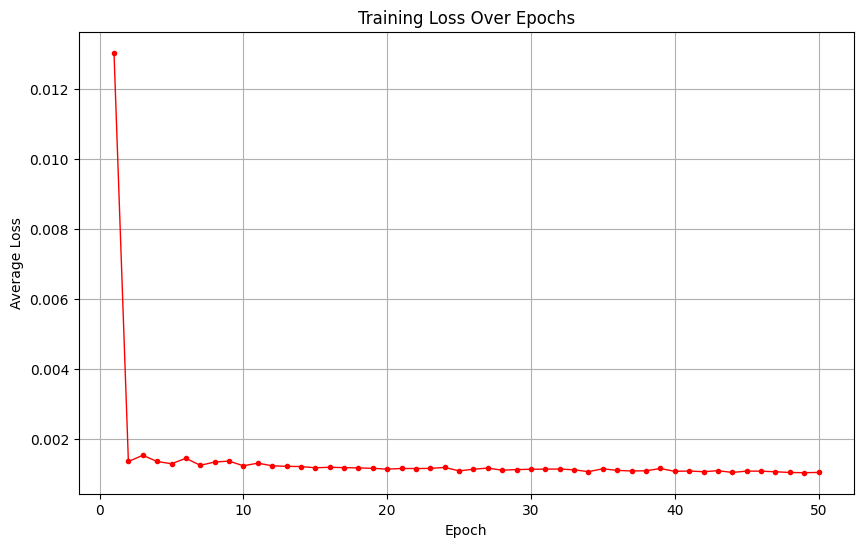

In [16]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='.', linestyle='-',linewidth=1, color='red')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.savefig('image_result/Bi-LSTM_training_loss.eps', bbox_inches='tight')
plt.show()

In [17]:
# Prediction
model.eval()  # Set the model to evaluation mode

# Prepare test data
test_inputs = torch.tensor([i[0] for i in test_sequences], dtype=torch.float32).to(device)
test_labels = torch.tensor([i[1] for i in test_sequences], dtype=torch.float32).to(device)

# Generate predictions
start_time=time.time()
with torch.no_grad():
    predictions = model(test_inputs).cpu().numpy()
    true_values = test_labels.cpu().numpy()
end_time=time.time()
print("Total test time:%f" % (end_time - start_time))

Total test time:0.094017


In [18]:
# Evaluate predictions
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)
evs = explained_variance_score(true_values, predictions)
mape = mean_absolute_percentage_error(true_values, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.0014213727554306388
Root Mean Squared Error: 0.03770109638571739
Mean Absolute Error: 0.02663162536919117
R^2 Score: 0.9960511005364863
Explained Variance Score: 0.9960704445838928
Mean Absolute Percentage Error: 0.07000723481178284


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


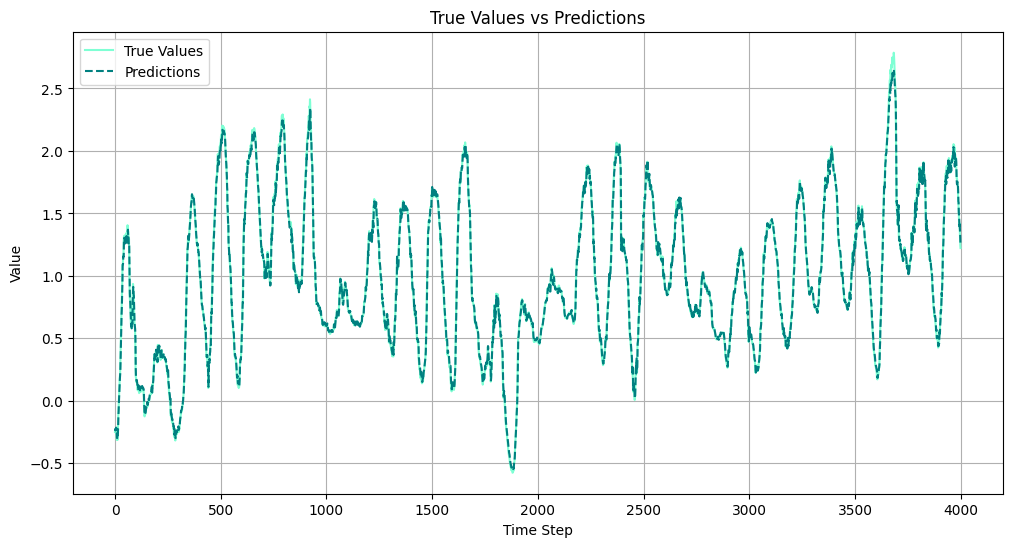

In [19]:
# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values', color='aquamarine')
plt.plot(predictions, label='Predictions', color='teal', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('True Values vs Predictions')
plt.legend()
plt.grid(True)
plt.savefig('image_result/Bi-LSTM_predictions_vs_true.eps', bbox_inches='tight')
plt.show()

In [20]:
# Compute FLOPs and MACs
dummy_input = torch.randn(1, timesteps, input_size).to(device)
macs, params = get_model_complexity_info(model, (timesteps, input_size), as_strings=False,
                                         print_per_layer_stat=True, verbose=True)

flops = macs * 2
print(f'FLOPs: {flops / 1e6:.7f} MFLOPs')
print(f'Number of parameters: {params}')

BiLSTM(
  535.81 k, 100.000% Params, 540.93 KMac, 100.000% MACs, 
  (lstm1): LSTM(140.29 k, 26.182% Params, 142.85 KMac, 26.408% MACs, 7, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(395.26 k, 73.770% Params, 397.82 KMac, 73.545% MACs, 256, 128, batch_first=True, bidirectional=True)
  (fc): Linear(257, 0.048% Params, 257.0 Mac, 0.048% MACs, in_features=256, out_features=1, bias=True)
)
FLOPs: 1.0818580 MFLOPs
Number of parameters: 535809
